In [1]:
import numpy as np
import meshpy.triangle

In [2]:

def create_mesh(boundary_points, max_area=0.025):
    info = meshpy.triangle.MeshInfo()
    info.set_points(boundary_points)

    def _round_trip_connect(start, end):
        return [(i, i + 1) for i in range(start, end)] + [(end, start)]

    info.set_facets(_round_trip_connect(0, len(boundary_points) - 1))

    def _needs_refinement(vertices, area):
        global points_array
        vert_origin, vert_destination, vert_apex = vertices
        bary_x = (vert_origin.x + vert_destination.x + vert_apex.x) / 3
        bary_y = (vert_origin.y + vert_destination.y + vert_apex.y) / 3
        offsets = [[point[0]-bary_x, point[1]-bary_y] for point in points_array]
        dist = [np.sqrt(point[0]**2 + point[1]**2) for point in offsets]
        boundary_dist = np.amin(dist)
        max_area = 250 * np.sqrt((boundary_dist+0.001))
        return area > max_area

    meshpy_mesh = meshpy.triangle.build(info, verbose=False, quality_meshing=True, min_angle=30, refinement_func=_needs_refinement, allow_boundary_steiner=True)
    pts = np.array(meshpy_mesh.points)
    points = np.c_[pts[:, 0], pts[:, 1], np.zeros(len(pts))]

    return points, np.array(meshpy_mesh.elements), np.array(meshpy_mesh.point_markers)


In [3]:


if __name__ == "__main__":
    import meshio    
    surface_points = np.load('./surface.npy')
    top_points = np.load('./top.npy')
    left_points = np.load('./left.npy')
    right_points = np.load('./right.npy')
    all_points = np.vstack((surface_points, right_points, top_points, left_points))
    
    global points_array
    points_array = np.array([[boundary_point[0], boundary_point[1]] for boundary_point in surface_points])
    points, triangles, boundary_markers = create_mesh(all_points, max_area=25000)


1001
[   0    1    2 ... 2052 2244 2748]
1001


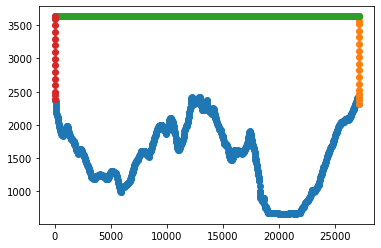

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
boundary_point_ids = np.extract(boundary_markers==1, np.arange(len(points)))
boundary_points = points[boundary_point_ids,:]
xmin = np.min(all_points, axis=0)[0]
xmax = np.max(all_points, axis=0)[0]
hmax = np.amax(all_points, axis=0)[1]

surface_points = np.array([point for point in boundary_points if point[0] > xmin and point[0] < xmax and point[1] < hmax])
surface_point_ids = np.array([boundary_point_ids[i] for i in range(len(boundary_points)) if boundary_points[i,0] > xmin and boundary_points[i,0] < xmax and boundary_points[i,1] < hmax])
top_points = np.array([point for point in boundary_points if point[0] > xmin and point[0] < xmax and np.abs(point[1]-hmax) <= 1])
top_point_ids = np.array([boundary_point_ids[i] for i in range(len(boundary_points)) if boundary_points[i,0] > xmin and boundary_points[i,0] < xmax and np.abs(boundary_points[i,1]-hmax) <= 1])
left_points = np.array([point for point in boundary_points if np.abs(point[0]-xmin) <= 1e-6])
left_point_ids = np.array([boundary_point_ids[i] for i in range(len(boundary_points)) if np.abs(boundary_points[i,0]-xmin) <= 1e-6])
right_points = np.array([point for point in boundary_points if np.abs(point[0]-xmax) <= 1e-6])
right_point_ids = np.array([boundary_point_ids[i] for i in range(len(boundary_points)) if np.abs(boundary_points[i,0]-xmax) <= 1e-6])

print(len(surface_points))
#surface_point_ids = [np.where(points == point) for point in surface_points]
print(surface_point_ids)
print(len(surface_point_ids))

for data in [surface_point_ids, right_point_ids, top_point_ids, left_point_ids]:
    plt.scatter(points[data,0], points[data,1])

In [68]:
surface_cells = [[i,i+1] for i in surface_point_ids]
top_cells = [[i,i+1] for i in top_point_ids]
left_cells = [[i,i+1] for i in left_point_ids]
right_cells = [[i,i+1] for i in right_point_ids]

In [70]:
    #TODO: Add line elements
    #TODO: Add physical groups
    #mesh = meshio.Mesh(points=points, cells=[("triangle", triangles)])
    mesh = meshio.Mesh(
        points=points, 
        cells=[("triangle", triangles), ('line', surface_cells), ('line', right_cells), ('line', top_cells), ('line', left_cells)],
        cell_data=[
            {"gmsh:physical": [[1 for tri in triangles], [2 for line in surface_cells], [3 for line in right_cells], [4 for line in top_cells], [5 for line in left_cells]]},
            {"gmsh:geometrical": [[1 for tri in triangles], [2 for line in surface_cells], [3 for line in right_cells], [4 for line in top_cells], [5 for line in left_cells]]}]
        )
    #mesh = meshio.Mesh(points=points, cells=[("triangle", cells), ('line', [[0,1], [1,2]])])
    print(mesh.cell_data)
    mesh.write("mesh.vtk")
    mesh.write("mesh.msh", file_format="gmsh22", binary=False)

AttributeError: 'list' object has no attribute 'items'